In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from src.cleantext import *

In [545]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Import Yelp dataset

In [230]:
data = pd.read_csv('../cap2/data/predicted_review.csv').drop(columns= ['business_id', 'user_id'])

In [ ]:
data['True(1)/Deceptive(0)'] = (data['True(1)/Deceptive(0)'] == 'True').astype(bool)

In [ ]:
type(data['True(1)/Deceptive(0)'][0])

**seperating to 2 dfs**

In [ ]:
true = data[data['True(1)/Deceptive(0)'] == 1]

In [ ]:
true.to_csv('true.csv')

In [ ]:
decep = data[data['True(1)/Deceptive(0)'] == 0]
decep.to_csv('decep.csv')

In [ ]:
true = pd.read_csv('true.csv').drop(columns='Unnamed: 0')

In [ ]:
decep = pd.read_csv('decep.csv').drop(columns='Unnamed: 0')

In [ ]:
true.isnull().sum()

In [ ]:
decep.isnull().sum()

Sample 100,000 data for faster processing

In [ ]:
true_samp = true.sample(100000, random_state = 123)

In [ ]:
decep_samp = decep.sample(100000, random_state = 123)

**pre processing the data**

clean text

In [ ]:
true_samp.Review = cleanText(true_samp.Review)

In [ ]:
decep_samp.Review = cleanText(decep_samp.Review)

tokenize

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
true_samp.Review = true_samp['Review'].apply(word_tokenize)

In [ ]:
decep_samp.Review = decep_samp['Review'].apply(word_tokenize)

Remove stopwords

In [ ]:
nltk.download('stopwords')

In [ ]:
stopwords_ = set(stopwords.words('english'))

In [ ]:
true_samp.Review = true_samp.Review.apply(lambda x: [item for item in x if item not in stopwords_ ])

In [ ]:
decep_samp.Review = decep_samp.Review.apply(lambda x: [item for item in x if item not in stopwords_ ])

Stemming

In [ ]:
stemmer = SnowballStemmer("english")
true_samp.Review = true_samp.Review.apply(lambda x: [stemmer.stem(y) for y in x])
decep_samp.Review = decep_samp.Review.apply(lambda x: [stemmer.stem(y) for y in x])

Detokenized

In [ ]:
true_samp.Review = true_samp.Review.apply(lambda x:' '.join([y for y in x ]))
decep_samp.Review = decep_samp.Review.apply(lambda x:' '.join([y for y in x ]))

In [ ]:
true_samp.to_csv('true_samp.csv')
decep_samp.to_csv('decep_samp.csv')

# Data Loaded to CSV checkpoint

In [221]:
true_samp = pd.read_csv('true_samp.csv')
true_samp.drop(columns='Unnamed: 0', inplace = True)

In [222]:
decep_samp = pd.read_csv('decep_samp.csv')
decep_samp.drop(columns='Unnamed: 0', inplace = True)

Vectorize

In [223]:
true_samp = true_samp[['Review', 'Stars']]

In [224]:
decep_samp = decep_samp[['Review','Stars']]

**use first 50k of sampled data for faster processing / able to keep track of the sample set**

In [7]:
true_samp.Review = true_samp.Review.fillna('None')

In [11]:
true_samp_vec = vectorize(true_samp[:50000]['Review'], max_feat= 1000)

In [26]:
decep_samp.Review = decep_samp.Review.fillna('None')

In [27]:
decep_samp_vec = vectorize(decep_samp[:50000]['Review'], max_feat= 1000)

Combine vector with other feature 

In [28]:
decep_samp_vec['Stars'] = decep_samp['Stars'][:50000]

In [ ]:
decep_samp_vec

In [17]:
true_samp_vec['Stars'] = true_samp['Stars'][:50000]

In [ ]:
true_samp_vec.iloc[:, :-1].values

Save vectors to pickle files

In [18]:
true_samp_vec.to_pickle('data/true_samp_vec_1000.pkl')

In [29]:
decep_samp_vec.to_pickle('data/decep_samp_vec_1000.pkl')

# Vectorized frames data checkpoint

In [4]:
true_samp_vec = pd.read_pickle('data/true_samp_vec_1000.pkl')
decep_samp_vec = pd.read_pickle('data/decep_samp_vec_1000.pkl')

In [435]:
true_samp_vec

,abl,absolut,accommod,across,actual,ad,add,addit,afternoon,ago,...,yelp,yes,yet,york,youll,young,your,yum,yummi,Stars
0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,5.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.284523,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,5.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,5.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.358341,0.0,0.0,0.0,0.0,0.0,4.0
49996,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,4.0
49997,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2.0
49998,0.0,0.0,0.0,0.0,0.0,0.0,0.14936,0.0,0.0,0.0,...,0.000000,0.147077,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,5.0


In [30]:
decep_samp_vec.head()

,abl,absolut,accommod,acknowledg,across,actual,ad,add,addit,adult,...,yes,yesterday,yet,york,youll,young,your,yum,yummi,Stars
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
4,0.0,0.0,0.122884,0.0,0.0,0.0,0.135446,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0


split

In [176]:
X_true_train, X_true_test = train_test_split(true_samp_vec.iloc[:, :-1].values, test_size = 0.2, random_state = 123)

In [177]:
X_true_train.shape

(40000, 1000)

In [178]:
X_true_test.shape

(10000, 1000)

# First Simple Auto Enconding Model

In [ ]:
# #model without rating feature
# model = Sequential()
# model.add(Dense(25, input_dim=X_true_train.shape[1], activation='relu'))
# model.add(Dense(3, activation='relu'))
# model.add(Dense(25, activation='relu'))
# model.add(Dense(X_true_train.shape[1])) # Multiple output neurons
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(X_true_train,X_true_train,verbose=1,epochs=100)

**MLP model vector without rating feature, epoch = 5**

In [32]:
model = Sequential()
model.add(Dense(25, input_dim=X_true_train.shape[1], activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(X_true_train.shape[1])) # Multiple output neurons
c = model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_true_train,X_true_train,verbose=1,epochs=5)

Train on 40000 samples
Epoch 1/5
40000/40000 [==============================] - 3s 68us/sample - loss: 9.4529e-04
Epoch 2/5
40000/40000 [==============================] - 2s 51us/sample - loss: 9.3040e-04
Epoch 3/5
40000/40000 [==============================] - 2s 52us/sample - loss: 9.2395e-040s - loss
Epoch 4/5
40000/40000 [==============================] - 2s 54us/sample - loss: 9.2215e-04
Epoch 5/5
40000/40000 [==============================] - 2s 56us/sample - loss: 9.2022e-04


In [ ]:
#MLP model.save('mlp_yelp_no_rating.h5')

In [33]:
pred = model.predict(X_true_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,X_true_test))
print(f"Insample True Reviews Score (RMSE): {score1}".format(score1))

Insample True Reviews Score (RMSE): 0.03033289194484629


In [34]:
pred = model.predict(true_samp_vec.iloc[:, :-1].values)
score2 = np.sqrt(metrics.mean_squared_error(pred,true_samp_vec.iloc[:, :-1].values))
print(f"Out of Sample True Reviews Score (RMSE): {score2}")

Out of Sample True Reviews Score (RMSE): 0.0303206738419857


In [35]:
pred = model.predict(decep_samp_vec.iloc[:, :-1].values)
score3 = np.sqrt(metrics.mean_squared_error(pred,decep_samp_vec.iloc[:, :-1].values))
print(f"Deceptive Reviews Score (RMSE): {score3}")

Deceptive Reviews Score (RMSE): 0.03165322070748198


**MLP model vector with rating feature, epoch = 5**

In [421]:
X_true_train, X_true_test = train_test_split(true_samp_vec.values, test_size = 0.2, random_state = 123)

In [424]:
X_true_train.shape

(40000, 1001)

In [433]:
X_true_test.shape

(10000, 1001)

In [434]:
#MLP model with rating feature
model = Sequential()
model.add(Dense(25, input_dim=X_true_train.shape[1], activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(X_true_train.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam' )
model.fit(X_true_train,X_true_train,verbose=1,epochs=5)

Train on 40000 samples
Epoch 1/5
40000/40000 [==============================] - 3s 74us/sample - loss: 0.0019
Epoch 2/5
40000/40000 [==============================] - 2s 54us/sample - loss: 9.5977e-04
Epoch 3/5
40000/40000 [==============================] - 2s 56us/sample - loss: 9.5305e-04
Epoch 4/5
40000/40000 [==============================] - 2s 56us/sample - loss: 9.4867e-04
Epoch 5/5
40000/40000 [==============================] - 2s 62us/sample - loss: 9.4224e-04


In [47]:
pred = model.predict(X_true_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,X_true_test))
pred = model.predict(true_samp_vec.values)
score2 = np.sqrt(metrics.mean_squared_error(pred,true_samp_vec.values))
pred = model.predict(decep_samp_vec.values)
score3 = np.sqrt(metrics.mean_squared_error(pred,decep_samp_vec.values))
print(f"Insample True Reviews Score (RMSE): {score1}".format(score1))
print(f"Out of Sample True Reviews Score (RMSE): {score2}")
print(f"Deceptive Reviews Score (RMSE): {score3}")

Insample True Reviews Score (RMSE): 0.030878646129114905
Out of Sample True Reviews Score (RMSE): 0.03086933004281668
Deceptive Reviews Score (RMSE): 0.031969273969535764


**MLP model with rating feature, increase epoch**

In [48]:
model = Sequential()
model.add(Dense(25, input_dim=X_true_train.shape[1], activation='relu'))
model.add(Dense(3, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(X_true_train.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam' )
model.fit(X_true_train,X_true_train,verbose=1,epochs=100)

Train on 40000 samples
Epoch 1/100
40000/40000 [==============================] - 2s 62us/sample - loss: 0.0020
Epoch 2/100
40000/40000 [==============================] - 2s 58us/sample - loss: 9.6395e-04
Epoch 3/100
40000/40000 [==============================] - 2s 62us/sample - loss: 9.5401e-040s - loss: 9.54
Epoch 4/100
40000/40000 [==============================] - 2s 54us/sample - loss: 9.5071e-04
Epoch 5/100
40000/40000 [==============================] - 2s 55us/sample - loss: 9.4747e-041s - loss: 9. - ETA: 0s - l
Epoch 6/100
40000/40000 [==============================] - 2s 55us/sample - loss: 9.4516e-040s - loss: 9.
Epoch 7/100
40000/40000 [==============================] - 2s 54us/sample - loss: 9.4338e-040s - loss: 
Epoch 8/100
40000/40000 [==============================] - 3s 63us/sample - loss: 9.4183e-04
Epoch 9/100
40000/40000 [==============================] - 3s 63us/sample - loss: 9.4083e-04
Epoch 10/100
40000/40000 [==============================] - 2s 58us/sample - l

40000/40000 [==============================] - 2s 59us/sample - loss: 9.1310e-04TA: 0s
Epoch 81/100
40000/40000 [==============================] - 2s 60us/sample - loss: 9.1310e-04
Epoch 82/100
40000/40000 [==============================] - 2s 53us/sample - loss: 9.1300e-04
Epoch 83/100
40000/40000 [==============================] - 2s 57us/sample - loss: 9.1298e-040s - l - ETA: 0s - loss: 9.1316
Epoch 84/100
40000/40000 [==============================] - 2s 51us/sample - loss: 9.1290e-04
Epoch 85/100
40000/40000 [==============================] - 2s 59us/sample - loss: 9.1295e-04
Epoch 86/100
40000/40000 [==============================] - 2s 57us/sample - loss: 9.1287e-040s - loss - ETA: 0s - loss: 9.1301e
Epoch 87/100
40000/40000 [==============================] - 2s 57us/sample - loss: 9.1281e-04
Epoch 88/100
40000/40000 [==============================] - 2s 54us/sample - loss: 9.1277e-040s - loss: 9.1269
Epoch 89/100
40000/40000 [==============================] - 2s 56us/sample - l

In [49]:
pred = model.predict(X_true_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,X_true_test))
pred = model.predict(true_samp_vec.values)
score2 = np.sqrt(metrics.mean_squared_error(pred,true_samp_vec.values))
pred = model.predict(decep_samp_vec.values)
score3 = np.sqrt(metrics.mean_squared_error(pred,decep_samp_vec.values))
print(f"Insample True Reviews Score (RMSE): {score1}".format(score1))
print(f"Out of Sample True Reviews Score (RMSE): {score2}")
print(f"Deceptive Reviews Score (RMSE): {score3}")

Insample True Reviews Score (RMSE): 0.030218103642040493
Out of Sample True Reviews Score (RMSE): 0.030201460947785495
Deceptive Reviews Score (RMSE): 0.031650776964433885


**more mlp**

In [182]:
model = Sequential()
model.add(Dense(200, input_dim=X_true_train.shape[1], activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(X_true_train.shape[1])) # Multiple output neurons
model.compile(loss='mean_squared_error', optimizer='adam' )
model.fit(X_true_train,X_true_train,verbose=1,epochs=10)

Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 4s 98us/sample - loss: 0.0013
Epoch 2/10
40000/40000 [==============================] - 4s 98us/sample - loss: 9.6960e-040
Epoch 3/10
40000/40000 [==============================] - 4s 91us/sample - loss: 9.5771e-04
Epoch 4/10
40000/40000 [==============================] - 4s 90us/sample - loss: 9.5161e-04
Epoch 5/10
40000/40000 [==============================] - 4s 89us/sample - loss: 9.4736e-04
Epoch 6/10
40000/40000 [==============================] - 4s 89us/sample - loss: 9.4209e-04
Epoch 7/10
40000/40000 [==============================] - 4s 92us/sample - loss: 9.3928e-04
Epoch 8/10
40000/40000 [==============================] - 3s 85us/sample - loss: 9.3710e-04
Epoch 9/10
40000/40000 [==============================] - 4s 96us/sample - loss: 9.3542e-04
Epoch 10/10
40000/40000 [==============================] - 4s 89us/sample - loss: 9.3385e-04


In [183]:
pred = model.predict(X_true_test)
score1 = np.sqrt(metrics.mean_squared_error(pred,X_true_test))
pred = model.predict(true_samp_vec.values)
score2 = np.sqrt(metrics.mean_squared_error(pred,true_samp_vec.values))
pred = model.predict(decep_samp_vec.values)
score3 = np.sqrt(metrics.mean_squared_error(pred,decep_samp_vec.values))
print(f"Insample True Reviews Score (RMSE): {score1}".format(score1))
print(f"Out of Sample True Reviews Score (RMSE): {score2}")
print(f"Deceptive Reviews Score (RMSE): {score3}")

Insample True Reviews Score (RMSE): 0.030559000089406357
Out of Sample True Reviews Score (RMSE): 0.030537694284503543
Deceptive Reviews Score (RMSE): 0.03186873998458336


# Trying LSTM Model

**USED SKLEARN VECTORIZER WHICH I WAS NOT SUPPOSED TO**

In [195]:
X_true_train, X_true_test = train_test_split(true_samp_vec, test_size = 0.2, random_state = 123)

In [196]:
X_true_train

,abl,absolut,accommod,across,actual,ad,add,addit,afternoon,ago,...,yelp,yes,yet,york,youll,young,your,yum,yummi,Stars
2660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.109985,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,5.0
32815,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.198144,0.0,0.0,0.0,0.0,4.0
35141,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.243964,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,5.0
19390,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,5.0
34846,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4.0
15377,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.0
17730,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,4.0
28030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,3.0


In [546]:
#imports for LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.externals import joblib
import tensorflow as tf
from tensorflow.keras.layers import Input, Dropout, Dense, LSTM, RepeatVector, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [198]:
#normalize data
scaler = MinMaxScaler()
X_true_train2 = scaler.fit_transform(X_true_train)
X_true_test2 = scaler.fit_transform(X_true_test)

In [199]:
#reshape for LSTM model
X_true_train2 = X_true_train.values.reshape(X_true_train2.shape[0], 1, X_true_train2.shape[1])
X_true_test2 = X_true_test.values.reshape(X_true_test2.shape[0], 1, X_true_test2.shape[1])
print(X_true_train2.shape, X_true_test2.shape)

(40000, 1, 1001) (10000, 1, 1001)


In [200]:
#define autoencoder network model
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(40, activation = 'relu', return_sequences = True)(inputs)
    L2 = LSTM(5, activation = 'relu', return_sequences = False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(5, activation = 'relu', return_sequences = True)(L3)
    L5 = LSTM(40, activation= 'relu', return_sequences = True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [448]:
model = autoencoder_model(X_true_train2)
model.compile(optimizer='adam', loss = 'mae')
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 1, 1001)]         0         
_________________________________________________________________
lstm_32 (LSTM)               (None, 1, 40)             166720    
_________________________________________________________________
lstm_33 (LSTM)               (None, 5)                 920       
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 1, 5)              0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 1, 5)              220       
_________________________________________________________________
lstm_35 (LSTM)               (None, 1, 40)             7360      
_________________________________________________________________
time_distributed_8 (TimeDist (None, 1, 1001)           4104

In [76]:
#fit model to the data
nb_epochs = 100
batch_size = 10
history = model.fit(X_true_train2, X_true_train2, epochs=nb_epochs, batch_size = batch_size, validation_split = 0.05).history

Train on 38000 samples, validate on 2000 samples
Epoch 1/100
38000/38000 [==============================] - 18s 483us/sample - loss: 0.0077 - val_loss: 0.0068
Epoch 2/100
38000/38000 [==============================] - 14s 381us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 3/100
38000/38000 [==============================] - 14s 373us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 4/100
38000/38000 [==============================] - 16s 417us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 5/100
38000/38000 [==============================] - 15s 384us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 6/100
38000/38000 [==============================] - 14s 380us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 7/100
38000/38000 [==============================] - 15s 386us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 8/100
38000/38000 [==============================] - 15s 397us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 9/100
38000/38000 [==============================] - 14s 380us/sa

38000/38000 [==============================] - 14s 361us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 75/100
38000/38000 [==============================] - 14s 361us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 76/100
38000/38000 [==============================] - 14s 360us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 77/100
38000/38000 [==============================] - 14s 361us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 78/100
38000/38000 [==============================] - 14s 363us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 79/100
38000/38000 [==============================] - 14s 379us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 80/100
38000/38000 [==============================] - 14s 367us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 81/100
38000/38000 [==============================] - 14s 359us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 82/100
38000/38000 [==============================] - 14s 364us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 83/100
3

In [78]:
#model.save('LSTM_yelp.h5')

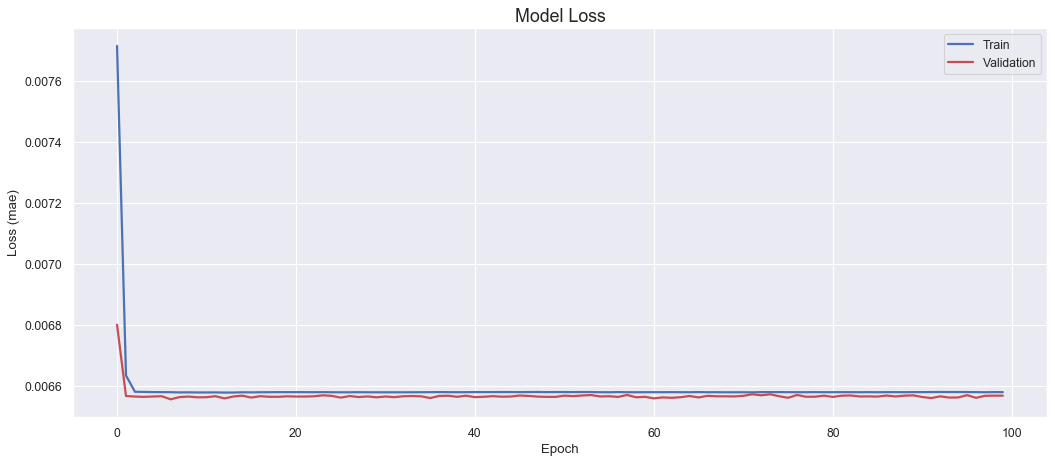

<Figure size 432x288 with 0 Axes>

In [101]:
#plot training losses
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set(color_codes = True)

fig,ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'],'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label ='Validation', linewidth = 2)
ax.set_title('Model Loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()
plt.savefig('img/training_loss.png')

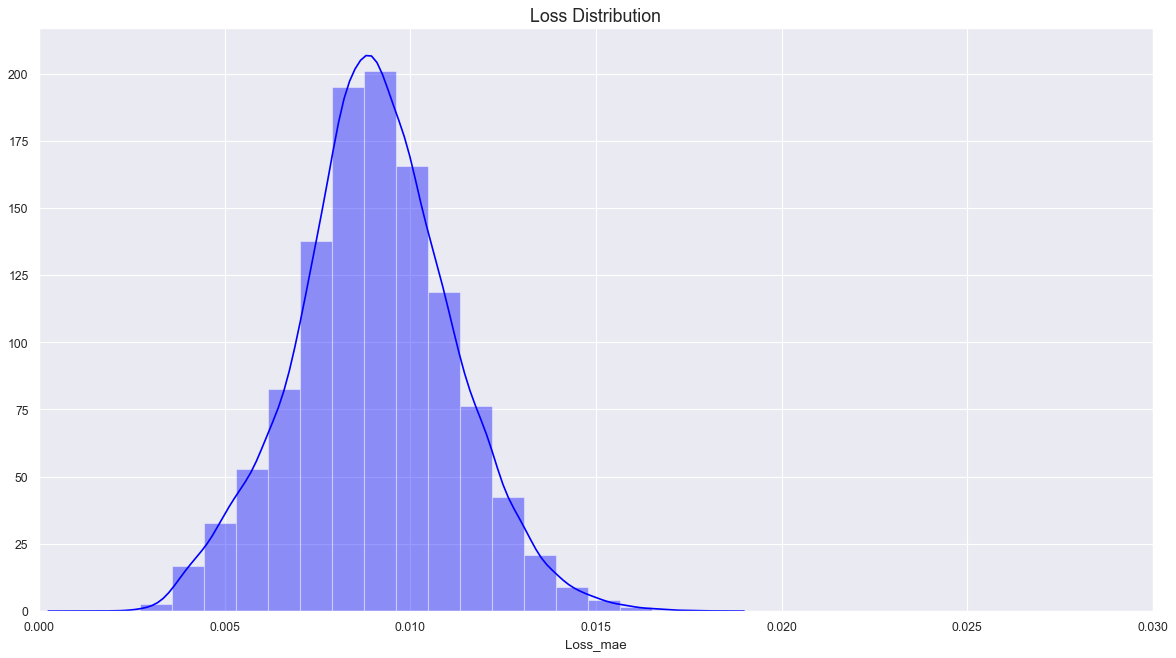

In [102]:
#plot  
X_pred = model.predict(X_true_train2)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns = X_true_train.columns)
X_pred.index = X_true_train.index

scored = pd.DataFrame(index = X_true_train.index)
Xtrain = X_true_train2.reshape(X_true_train2.shape[0], X_true_train2.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize= 16)
sns.distplot(scored['Loss_mae'], bins =20, kde= True, color= 'blue');
plt.xlim([0.0,0.03])
plt.savefig('img/loss_dist_train.png')

In [103]:
#calculate loss on test set
X_pred = model.predict(X_true_test2)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns = X_true_test.columns)
X_pred.index = X_true_test.index

scored = pd.DataFrame(index = X_true_test.index)
Xtest = X_true_test2.reshape(X_true_test2.shape[0], X_true_test2.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis=1)
scored['Threshold'] = 0.02 #testing Threshold at 0.02 according to the histogram
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
11872,0.008233,0.02,False
40828,0.011485,0.02,False
36400,0.009150,0.02,False
5166,0.010091,0.02,False
30273,0.006181,0.02,False


In [104]:
#calculate the same metrics for the training set and merge all data in single DF for plotting
X_pred_train = model.predict(X_true_train2)
X_pred_train = X_pred_train.reshape(X_pred_train.shape[0], X_pred_train.shape[2])
X_pred_train = pd.DataFrame(X_pred_train, columns = X_true_train.columns)
X_pred_train.index = X_true_train.index

scored_train = pd.DataFrame(index= X_true_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-Xtrain), axis = 1)
scored_train['Threshold'] = 0.02
scored_train['Anomaly'] = scored_train['Loss_mae']> scored_train['Threshold']
scored = pd.concat([scored_train,scored])

In [112]:
scored[scored['Anomaly'] ==True]

,Loss_mae,Threshold,Anomaly


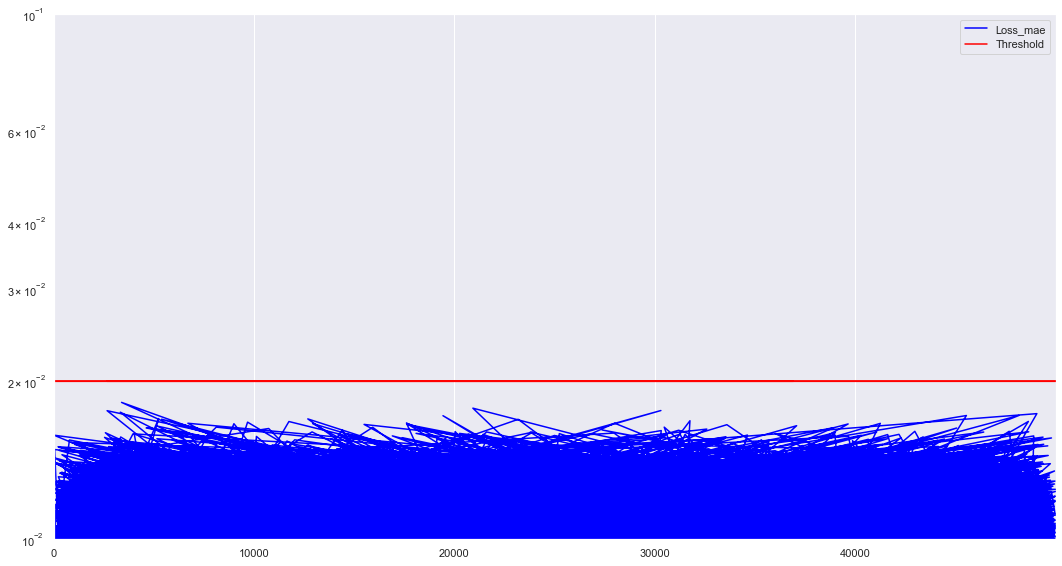

In [114]:
scored.plot(logy= True, figsize=(16,9), color = ['blue','red'], ylim = [1e-2,1e-1])

CHECK WITH DECEPTIVE DATA TO SEE IF IT'S AN ANOMALY

In [141]:
decep_ = decep_samp_vec.iloc[:10000]

In [142]:
decep_

,abl,absolut,accommod,acknowledg,across,actual,ad,add,addit,adult,...,yes,yesterday,yet,york,youll,young,your,yum,yummi,Stars
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0
4,0.0,0.0,0.122884,0.0,0.0,0.0,0.135446,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0
9996,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0
9997,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.0
9998,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0


In [143]:
#normalize data
scaler = MinMaxScaler()
decep = scaler.fit_transform(decep_)

#reshape for LSTM model
decep = decep.reshape(decep.shape[0], 1, decep.shape[1])
decep.shape

(10000, 1, 1001)

In [144]:
decep

array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 1.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 1.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 1.        ]],

       ...,

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.25      ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 1.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.29682166, 1.        ]]])

In [145]:
decep_

,abl,absolut,accommod,acknowledg,across,actual,ad,add,addit,adult,...,yes,yesterday,yet,york,youll,young,your,yum,yummi,Stars
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0
1,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0
4,0.0,0.0,0.122884,0.0,0.0,0.0,0.135446,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0
9996,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0
9997,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.0
9998,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.0


In [147]:
X_true_test2.shape

(10000, 1001)

In [150]:
#calculate loss on deceptive set
X_pred = model.predict(decep)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns = decep_.columns)
X_pred.index = decep_.index

scored = pd.DataFrame(index = decep_.index)
Xtest = X_true_test2.reshape(X_true_test2.shape[0], X_true_test2.shape[1])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis=1)
scored['Threshold'] = 0.02 #testing Threshold at 0.02 according to the histogram
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored

,Loss_mae,Threshold,Anomaly
0,0.007858,0.02,False
1,0.018710,0.02,False
2,0.010992,0.02,False
3,0.015011,0.02,False
4,0.009930,0.02,False
...,...,...,...
9995,0.007781,0.02,False
9996,0.009849,0.02,False
9997,0.010511,0.02,False
9998,0.013817,0.02,False


In [152]:
scored[scored['Anomaly']==True]

,Loss_mae,Threshold,Anomaly
76,0.020822,0.02,True
172,0.020983,0.02,True
220,0.020467,0.02,True
351,0.020382,0.02,True
497,0.020645,0.02,True
...,...,...,...
9332,0.021062,0.02,True
9345,0.021420,0.02,True
9607,0.020991,0.02,True
9637,0.020514,0.02,True


NEW LSTM Model with less epoch to avoid overfitting

In [202]:
#fit model to the data
nb_epochs = 3
batch_size = 10
history = model.fit(X_true_train2, X_true_train2, epochs=nb_epochs, batch_size = batch_size, validation_split = 0.05).history

Train on 38000 samples, validate on 2000 samples
Epoch 1/3
38000/38000 [==============================] - 27s 703us/sample - loss: 0.0077 - val_loss: 0.0068
Epoch 2/3
38000/38000 [==============================] - 20s 517us/sample - loss: 0.0066 - val_loss: 0.0066
Epoch 3/3
38000/38000 [==============================] - 18s 477us/sample - loss: 0.0066 - val_loss: 0.0066


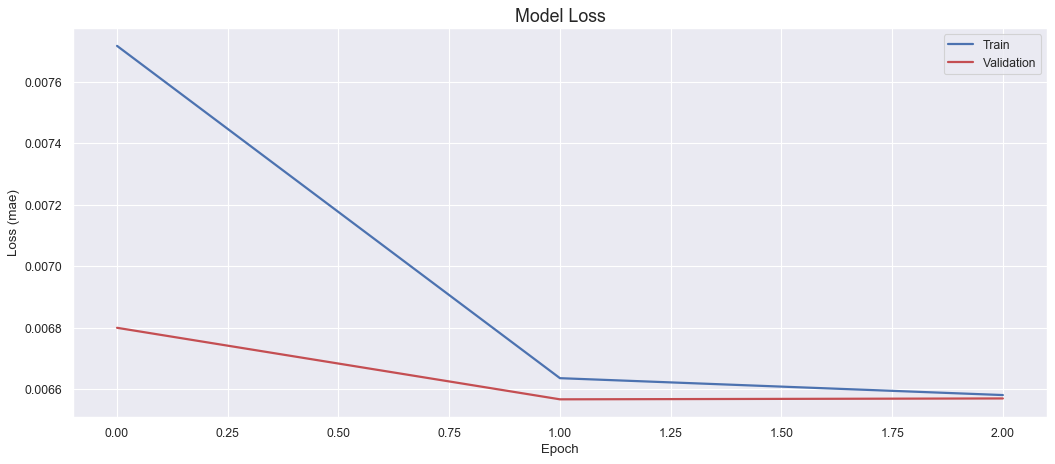

<Figure size 432x288 with 0 Axes>

In [203]:
#plot training losses
%matplotlib inline
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set(color_codes = True)

fig,ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'],'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label ='Validation', linewidth = 2)
ax.set_title('Model Loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()
plt.savefig('img/training_loss.png')

(0.0, 0.03)

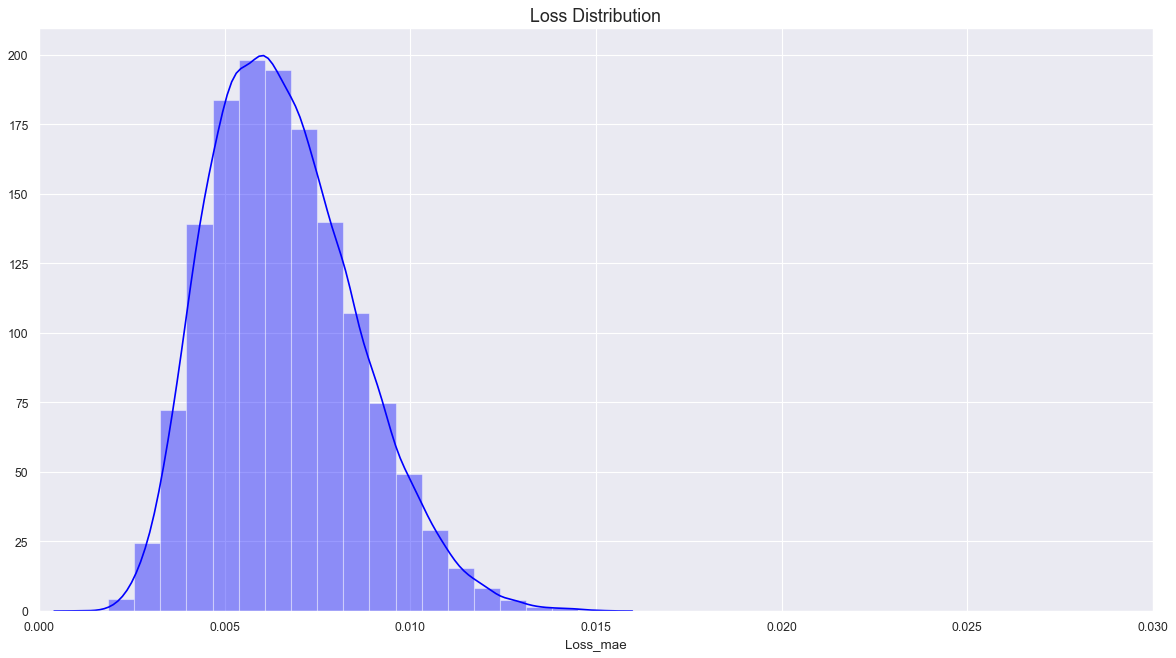

In [204]:
#plot loss distribution of the training set
X_pred = model.predict(X_true_train2)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[1])
X_pred = pd.DataFrame(X_pred, columns = X_true_train.columns)
X_pred.index = X_true_train.index

scored = pd.DataFrame(index = X_true_train.index)
Xtrain = X_true_train2.reshape(X_true_train2.shape[0], X_true_train2.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize= 16)
sns.distplot(scored['Loss_mae'], bins =20, kde= True, color= 'blue');
plt.xlim([0.0,0.03])

In [218]:
#calculate loss on deceptive set
X_pred = model.predict(decep)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns = decep_.columns)
X_pred.index = decep_.index

scored = pd.DataFrame(index = decep_.index)
Xtest = X_true_test2.reshape(X_true_test2.shape[0], X_true_test2.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtest), axis=1)
scored['Threshold'] = 0.01 #testing Threshold at 0.01/ 0.015 according to the histogram return no outliers
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored

,Loss_mae,Threshold,Anomaly
0,0.004355,0.01,False
1,0.011581,0.01,True
2,0.005294,0.01,False
3,0.008205,0.01,False
4,0.008322,0.01,False
...,...,...,...
9995,0.006469,0.01,False
9996,0.005998,0.01,False
9997,0.007091,0.01,False
9998,0.007565,0.01,False


In [219]:
scored[scored['Anomaly'] == True]

,Loss_mae,Threshold,Anomaly
1,0.011581,0.01,True
7,0.010633,0.01,True
10,0.010884,0.01,True
54,0.011371,0.01,True
67,0.010278,0.01,True
...,...,...,...
9920,0.010074,0.01,True
9944,0.010062,0.01,True
9967,0.011399,0.01,True
9968,0.010153,0.01,True


**TRY PLOTTING THE DECEPTIVE REVIEWS LOSS DISTRIBUTION**

# CORRECT Tensorflow VEC to use with the LSTM model

In [339]:
def clean_for_tf(wordSeries):
    def remove_accents(input_str):
        nfkd_form = unicodedata.normalize('NFKD', input_str)
        only_ascii = nfkd_form.encode('ASCII', 'ignore')
        return only_ascii.decode()    
    
    wordSeries = wordSeries.apply(lambda x: remove_accents(x))
    wordSeries = wordSeries.apply(lambda x: x.lower())
    stopwords_ = set(stopwords.words('english'))
    wordSeries = wordSeries.apply(lambda x: [item for item in x.split() if item not in stopwords_])
    wordSeries = wordSeries.apply(lambda x:' '.join([y for y in x ]))
    return wordSeries

In [466]:
#load the preprocess text data frame
true = pd.read_csv('true.csv').drop(columns=['Unnamed: 0', 'True(1)/Deceptive(0)'])

In [467]:
decep = pd.read_csv('decep.csv').drop(columns=['Unnamed: 0', 'True(1)/Deceptive(0)'])

In [468]:
true_samp = true.sample(100000, random_state = 123)
decep_samp = decep.sample(100000, random_state = 123)

In [469]:
true_samp

,Review,Stars
1163222,One of our local FAVES! My mom and her friend ...,5.0
1193951,We were nearby and this was highly rated by Ye...,4.0
733616,Rolling with 5 stars here because if you want ...,5.0
578171,My review of the Side Door is way overdue. Thi...,5.0
1054178,"Typical lodge. Gambling, drinks, food, tv with...",4.0
...,...,...
1217344,"Not much on the menu, or I guess I should say ...",3.0
895571,Food is really good and of a reasonable price!...,5.0
1071734,I have to admit that when I came from LA to Ar...,5.0
381435,I have been wanting to come here for a few wee...,5.0


In [427]:
true_samp.Review = clean_for_tf(true_samp.Review)

In [428]:
decep_samp.Review = clean_for_tf(decep_samp.Review)

In [429]:
#clean_for_tf
true_samp

,Review,Stars
1163222,one local faves! mom friend weekly standing da...,5.0
1193951,nearby highly rated yelp took plunge. place de...,4.0
733616,rolling 5 stars want pizza 3 4am stumble place...,5.0
578171,review side door way overdue. go-to neighborho...,5.0
1054178,"typical lodge. gambling, drinks, food, tv spor...",4.0
...,...,...
1217344,"much menu, guess say i'm really creative dishe...",3.0
895571,food really good reasonable price! arepas may ...,5.0
1071734,admit came la arizona visit boyfriend first ti...,5.0
381435,wanting come weeks finally area need lunch. ad...,5.0


In [465]:
#max num of words to be used(most frequent)
max_nb_words = 5000
#max num of words in each complaint(max words out of all reviews)
max_sequence_len = 579
#embedding_dim
embeddind_dim = 100

In [401]:
#find max num of words in reviews
max(true_samp.Review.str.count(' ') + 1)

579

In [359]:
max(decep_samp.Review.str.count(' ') + 1)

742

In [402]:
tokenizer.fit_on_texts(true_samp.Review.values)

tokenizer.fit_on_texts(true_samp.Review.values)
word_index = tokenizer.word_index
print(f'Found %s unique tokens.'%len(word_index))

Found 73265 unique tokens.


In [403]:
X = tokenizer.texts_to_sequences(true_samp.Review.values)
X = pad_sequences(X, maxlen= max_sequence_len)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (100000, 579)


In [380]:
stars =true_samp.Stars.values

In [404]:
#add rating feature to the array
X = np.hstack((X, stars.reshape(100000,1)))

In [452]:
X.shape

(100000, 580)

In [453]:
X_train, X_test = train_test_split(X, test_size = 0.2, random_state=123)

In [454]:
X_test

array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 4.100e+01, 1.000e+01,
        5.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.490e+02, 6.400e+01,
        5.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 2.943e+03, 1.043e+03,
        1.000e+00],
       ...,
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.263e+03, 1.084e+03,
        2.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 1.000e+00, 4.030e+02,
        1.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 3.290e+02, 7.560e+02,
        3.000e+00]])

In [438]:
#reshape for LSTM model
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train2.shape, X_test2.shape)

(80000, 1, 580) (20000, 1, 580)


In [410]:
def autoencoder_model(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(40, activation = 'relu', return_sequences = True)(inputs)
    L2 = LSTM(5, activation = 'relu', return_sequences = False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(5, activation = 'relu', return_sequences = True)(L3)
    L5 = LSTM(40, activation= 'relu', return_sequences = True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [411]:
model = autoencoder_model(X_train2)
model.compile(optimizer='adam', loss = 'mae')
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 1, 580)]          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 1, 40)             99360     
_________________________________________________________________
lstm_17 (LSTM)               (None, 5)                 920       
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 1, 5)              0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 1, 5)              220       
_________________________________________________________________
lstm_19 (LSTM)               (None, 1, 40)             7360      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 1, 580)            2378

In [417]:
#fit model to the data
nb_epochs = 20
batch_size = 10
history = model.fit(X_train2, X_train2, epochs=nb_epochs, batch_size = batch_size, validation_split = 0.05).history

Train on 76000 samples, validate on 4000 samples
Epoch 1/20
76000/76000 [==============================] - 31s 409us/sample - loss: 62.6189 - val_loss: 63.3456
Epoch 2/20
76000/76000 [==============================] - 30s 398us/sample - loss: 62.5465 - val_loss: 63.3222
Epoch 3/20
76000/76000 [==============================] - 30s 399us/sample - loss: 62.5006 - val_loss: 63.2238
Epoch 4/20
76000/76000 [==============================] - 30s 400us/sample - loss: 62.4797 - val_loss: 63.2457
Epoch 5/20
76000/76000 [==============================] - 30s 400us/sample - loss: 62.4537 - val_loss: 63.1889
Epoch 6/20
76000/76000 [==============================] - 30s 398us/sample - loss: 62.4307 - val_loss: 63.1715
Epoch 7/20
76000/76000 [==============================] - 30s 396us/sample - loss: 62.4228 - val_loss: 63.2185
Epoch 8/20
76000/76000 [==============================] - 30s 399us/sample - loss: 62.4179 - val_loss: 63.1631
Epoch 9/20
76000/76000 [==============================] - 30s 3

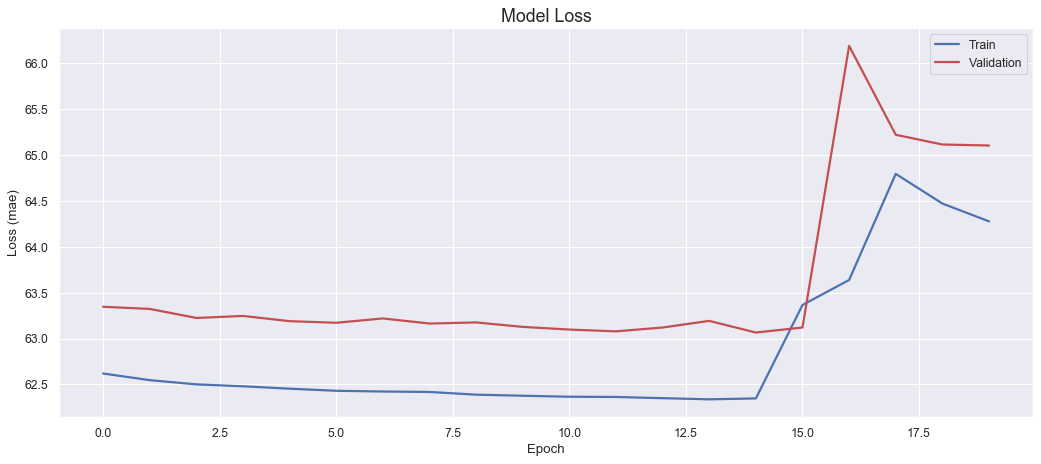

<Figure size 432x288 with 0 Axes>

In [418]:
#plot training losses

fig,ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'],'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label ='Validation', linewidth = 2)
ax.set_title('Model Loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [419]:
#fit model to the data
nb_epochs = 50
batch_size = 10
history = model.fit(X_train2, X_train2, epochs=nb_epochs, batch_size = batch_size, validation_split = 0.05).history

Train on 76000 samples, validate on 4000 samples
Epoch 1/50
76000/76000 [==============================] - 35s 455us/sample - loss: 65.0890 - val_loss: 67.0813
Epoch 2/50
76000/76000 [==============================] - 34s 443us/sample - loss: 65.5065 - val_loss: 65.9290
Epoch 3/50
76000/76000 [==============================] - 32s 423us/sample - loss: 64.8232 - val_loss: 65.3761
Epoch 4/50
76000/76000 [==============================] - 32s 427us/sample - loss: 64.4092 - val_loss: 65.0888
Epoch 5/50
76000/76000 [==============================] - 32s 421us/sample - loss: 64.1807 - val_loss: 64.9615
Epoch 6/50
76000/76000 [==============================] - 33s 437us/sample - loss: 64.0306 - val_loss: 64.8142
Epoch 7/50
76000/76000 [==============================] - 32s 426us/sample - loss: 63.9470 - val_loss: 64.7693
Epoch 8/50
76000/76000 [==============================] - 32s 420us/sample - loss: 63.8788 - val_loss: 64.6888
Epoch 9/50
76000/76000 [==============================] - 32s 4

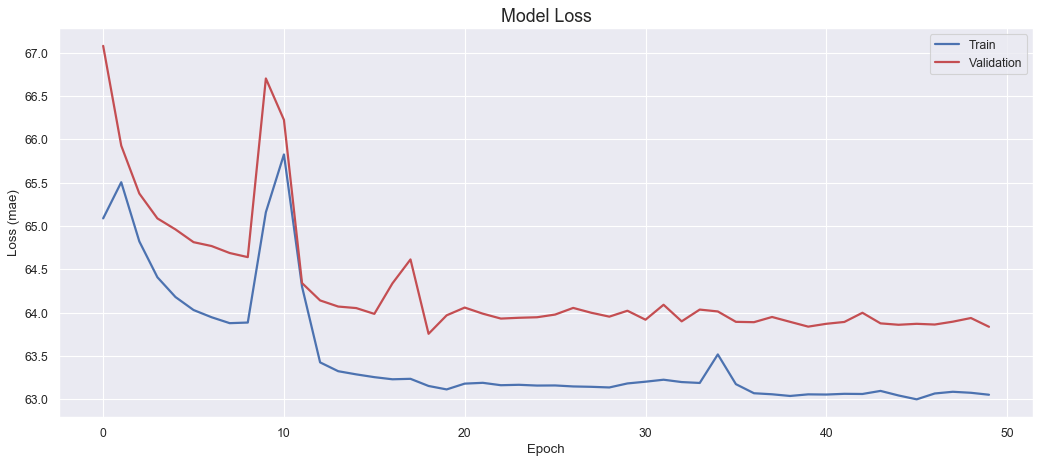

In [420]:
#plot training losses

fig,ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'],'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label ='Validation', linewidth = 2)
ax.set_title('Model Loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [439]:
def autoencoder_model2(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(30, activation = 'relu', return_sequences = True)(inputs)
    L2 = LSTM(5, activation = 'relu', return_sequences = False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(5, activation = 'relu', return_sequences = True)(L3)
    L5 = LSTM(30, activation= 'relu', return_sequences = True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [440]:
model = autoencoder_model2(X_train2)
model.compile(optimizer='adam', loss = 'mae')
model.summary()
#fit model to the data
nb_epochs = 20
batch_size = 10
history = model.fit(X_train2, X_train2, epochs=nb_epochs, batch_size = batch_size, validation_split = 0.05).history

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 1, 580)]          0         
_________________________________________________________________
lstm_20 (LSTM)               (None, 1, 30)             73320     
_________________________________________________________________
lstm_21 (LSTM)               (None, 5)                 720       
_________________________________________________________________
repeat_vector_5 (RepeatVecto (None, 1, 5)              0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 1, 5)              220       
_________________________________________________________________
lstm_23 (LSTM)               (None, 1, 30)             4320      
_________________________________________________________________
time_distributed_5 (TimeDist (None, 1, 580)            1798

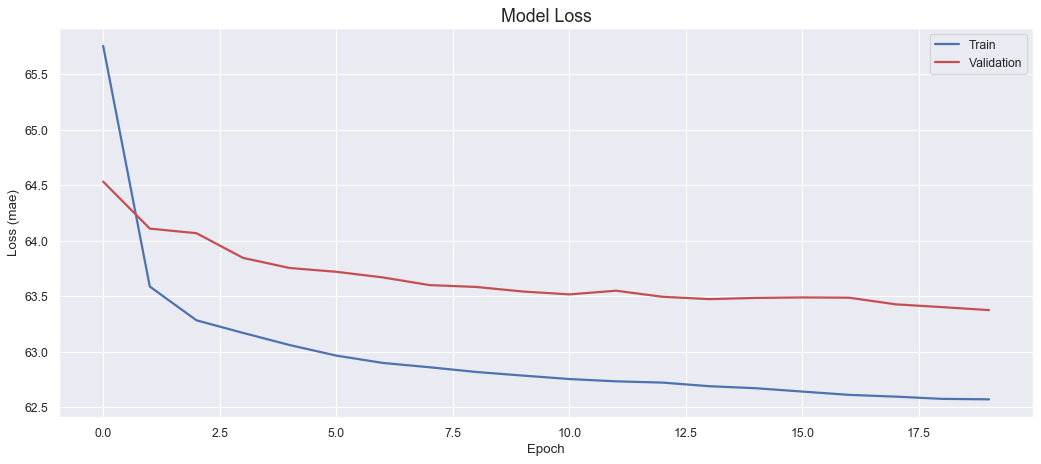

In [441]:
fig,ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'],'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label ='Validation', linewidth = 2)
ax.set_title('Model Loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [442]:
def autoencoder_model3(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(20, activation = 'relu', return_sequences = True)(inputs)
    L2 = LSTM(5, activation = 'relu', return_sequences = False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(5, activation = 'relu', return_sequences = True)(L3)
    L5 = LSTM(20, activation= 'relu', return_sequences = True)(L4)
    output = TimeDistributed(Dense(X.shape[2]))(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [443]:
model = autoencoder_model3(X_train2)
model.compile(optimizer='adam', loss = 'mae')
model.summary()
#fit model to the data
nb_epochs = 20
batch_size = 10
history = model.fit(X_train2, X_train2, epochs=nb_epochs, batch_size = batch_size, validation_split = 0.05).history

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 1, 580)]          0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 1, 20)             48080     
_________________________________________________________________
lstm_25 (LSTM)               (None, 5)                 520       
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 1, 5)              0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 1, 5)              220       
_________________________________________________________________
lstm_27 (LSTM)               (None, 1, 20)             2080      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 1, 580)            1218

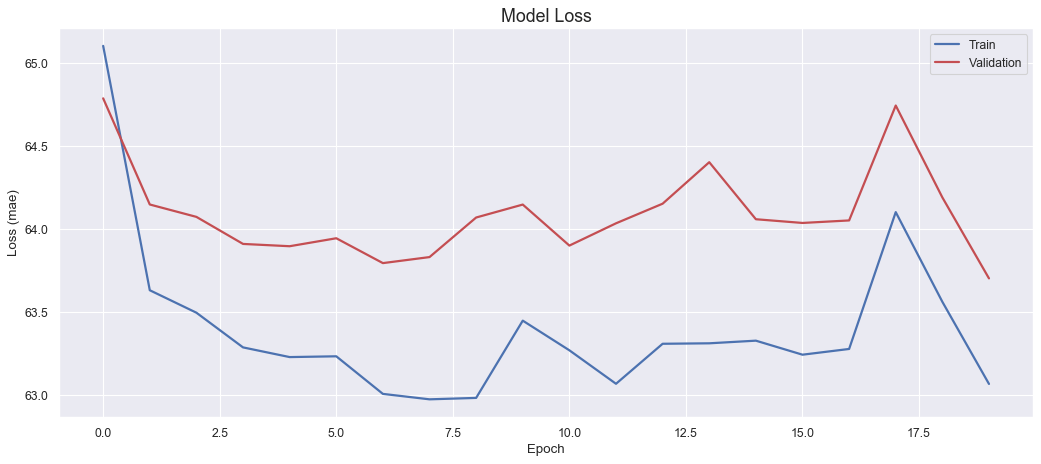

In [445]:
fig,ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'],'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label ='Validation', linewidth = 2)
ax.set_title('Model Loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

In [446]:
model = autoencoder_model2(X_train2)
model.compile(optimizer='adam', loss = 'mae')
model.summary()
#fit model to the data
nb_epochs = 20
batch_size = 5
history = model.fit(X_train2, X_train2, epochs=nb_epochs, batch_size = batch_size, validation_split = 0.05).history

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 580)]          0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 1, 30)             73320     
_________________________________________________________________
lstm_29 (LSTM)               (None, 5)                 720       
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 1, 5)              0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 1, 5)              220       
_________________________________________________________________
lstm_31 (LSTM)               (None, 1, 30)             4320      
_________________________________________________________________
time_distributed_7 (TimeDist (None, 1, 580)            1798

In [451]:
model = autoencoder_model2(X_train2)
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.summary()
#fit model to the data
nb_epochs = 30
batch_size = 10
history = model.fit(X_train2, X_train2, epochs=nb_epochs, batch_size = batch_size, validation_split = 0.05).history

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 1, 580)]          0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 1, 30)             73320     
_________________________________________________________________
lstm_41 (LSTM)               (None, 5)                 720       
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 1, 5)              0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 1, 5)              220       
_________________________________________________________________
lstm_43 (LSTM)               (None, 1, 30)             4320      
_________________________________________________________________
time_distributed_10 (TimeDis (None, 1, 580)            1798

# *REDO*, tokenize with RAW text
- with rating feature
- NO normalize (per Hamid)

In [475]:
true_samp.head()

,Review,Stars
1163222,One of our local FAVES! My mom and her friend ...,5.0
1193951,We were nearby and this was highly rated by Ye...,4.0
733616,Rolling with 5 stars here because if you want ...,5.0
578171,My review of the Side Door is way overdue. Thi...,5.0
1054178,"Typical lodge. Gambling, drinks, food, tv with...",4.0


In [476]:
decep_samp.head()

,Review,Stars
311475,Always amazing food! \r\nIt is a great place f...,5.0
312772,Randy Randy Randy! He is the guy you want as y...,5.0
369595,I ordered from here on uber eats. The food was...,5.0
413443,What a great find! It's hidden behind a dance ...,5.0
205704,Went here for dinner the other night with cowo...,5.0


In [473]:
#max num of words to be used(most frequent)
max_nb_words = 5000
#max num of words in each complaint(max words out of all reviews)
max_sequence_len = 300
#embedding_dim
embeddind_dim = 100

In [478]:
#tokenize utilizing keras tokenizer
tokenizer = Tokenizer(num_words=max_nb_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(true_samp.Review.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 89711 unique tokens.


In [512]:
word_index

{'the': 1,
 'and': 2,
 'a': 3,
 'i': 4,
 'to': 5,
 'was': 6,
 'of': 7,
 'it': 8,
 'is': 9,
 'for': 10,
 'in': 11,
 'we': 12,
 'with': 13,
 'but': 14,
 'that': 15,
 'my': 16,
 'this': 17,
 'on': 18,
 'they': 19,
 'you': 20,
 'food': 21,
 'had': 22,
 'not': 23,
 'were': 24,
 'have': 25,
 'good': 26,
 'so': 27,
 'place': 28,
 'at': 29,
 'are': 30,
 'be': 31,
 'as': 32,
 'very': 33,
 'great': 34,
 'our': 35,
 'like': 36,
 'here': 37,
 'just': 38,
 'there': 39,
 'all': 40,
 'out': 41,
 'if': 42,
 'service': 43,
 'me': 44,
 'one': 45,
 'get': 46,
 'time': 47,
 'their': 48,
 'or': 49,
 'back': 50,
 'from': 51,
 "it's": 52,
 'go': 53,
 'when': 54,
 'would': 55,
 'really': 56,
 'which': 57,
 'up': 58,
 'about': 59,
 'ordered': 60,
 'some': 61,
 'an': 62,
 'will': 63,
 'us': 64,
 'what': 65,
 'order': 66,
 'been': 67,
 'chicken': 68,
 'also': 69,
 'no': 70,
 'more': 71,
 'got': 72,
 'your': 73,
 'only': 74,
 'can': 75,
 'restaurant': 76,
 'too': 77,
 'because': 78,
 'by': 79,
 "don't": 80,
 'men

In [510]:
tokenizer.fit_on_texts(decep_samp[:80000].Review.values)
word_index_decep = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 89711 unique tokens.


In [511]:
word_index_decep

{'the': 1,
 'and': 2,
 'a': 3,
 'i': 4,
 'to': 5,
 'was': 6,
 'of': 7,
 'is': 8,
 'it': 9,
 'for': 10,
 'in': 11,
 'we': 12,
 'this': 13,
 'with': 14,
 'my': 15,
 'but': 16,
 'food': 17,
 'that': 18,
 'you': 19,
 'they': 20,
 'on': 21,
 'had': 22,
 'good': 23,
 'have': 24,
 'not': 25,
 'were': 26,
 'place': 27,
 'so': 28,
 'great': 29,
 'are': 30,
 'at': 31,
 'be': 32,
 'service': 33,
 'very': 34,
 'as': 35,
 'our': 36,
 'here': 37,
 'there': 38,
 'all': 39,
 'out': 40,
 'like': 41,
 'just': 42,
 'time': 43,
 'if': 44,
 'one': 45,
 'back': 46,
 'their': 47,
 'get': 48,
 'me': 49,
 'go': 50,
 'from': 51,
 "it's": 52,
 'or': 53,
 'would': 54,
 'when': 55,
 'really': 56,
 'will': 57,
 'which': 58,
 'up': 59,
 'about': 60,
 'best': 61,
 'been': 62,
 'us': 63,
 'restaurant': 64,
 'ordered': 65,
 'an': 66,
 'order': 67,
 'some': 68,
 'also': 69,
 'what': 70,
 'chicken': 71,
 'love': 72,
 'your': 73,
 'no': 74,
 'more': 75,
 'delicious': 76,
 'only': 77,
 'can': 78,
 'got': 79,
 'nice': 80,
 

In [513]:
X_decep = tokenizer.texts_to_sequences(decep_samp[:80000].Review.values)
X_decep = pad_sequences(X_decep, maxlen=max_sequence_len)

In [514]:
print('Shape of data tensor:', X_decep.shape)

Shape of data tensor: (80000, 300)


In [479]:
X = tokenizer.texts_to_sequences(true_samp.Review.values)
X = pad_sequences(X, maxlen=max_sequence_len)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (100000, 300)


In [480]:
#rating feature
stars =true_samp.Stars.values

In [481]:
#add rating feature to the vector
X = np.hstack((X, stars.reshape(100000,1)))

In [482]:
#split data for test and train
X_train, X_test = train_test_split(X, test_size = 0.2, random_state=123)

In [484]:
#reshape for LSTM model
X_train2 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test2 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
print(X_train2.shape, X_test2.shape)

(80000, 1, 301) (20000, 1, 301)


In [515]:
#X_decep2 = X_decep.reshape(X_decep.shape[0], 1, X_decep.shape[1])

In [538]:
def autoencoder_model_new(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(40, activation = 'relu', return_sequences = True)(inputs)
    L2 = LSTM(5, activation = 'relu', return_sequences = False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(5, activation = 'relu', return_sequences = True)(L3)
    L5 = LSTM(40, activation= 'relu', return_sequences = True)(L4)
    output = Dense(X.shape[2])(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [543]:
model = autoencoder_model_new(X_train2)
model.compile(optimizer='adam', loss = 'mae')
model.summary()

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        [(None, 1, 301)]          0         
_________________________________________________________________
lstm_64 (LSTM)               (None, 1, 40)             54720     
_________________________________________________________________
lstm_65 (LSTM)               (None, 5)                 920       
_________________________________________________________________
repeat_vector_16 (RepeatVect (None, 1, 5)              0         
_________________________________________________________________
lstm_66 (LSTM)               (None, 1, 5)              220       
_________________________________________________________________
lstm_67 (LSTM)               (None, 1, 40)             7360      
_________________________________________________________________
dense_72 (Dense)             (None, 1, 301)            123

In [544]:
#fit model to the data
nb_epochs = 10
batch_size = 10
history = model.fit(X_train2, X_train2, epochs=nb_epochs, batch_size = batch_size, validation_split = 0.1).history

Train on 72000 samples, validate on 8000 samples
Epoch 1/10
72000/72000 [==============================] - 31s 433us/sample - loss: 141.2041 - val_loss: 140.4272
Epoch 2/10
72000/72000 [==============================] - 31s 435us/sample - loss: 140.4551 - val_loss: 139.6323
Epoch 3/10
72000/72000 [==============================] - 30s 413us/sample - loss: 140.2923 - val_loss: 139.5158
Epoch 4/10
72000/72000 [==============================] - 29s 406us/sample - loss: 140.1950 - val_loss: 139.4226
Epoch 5/10
72000/72000 [==============================] - 29s 403us/sample - loss: 140.1344 - val_loss: 139.3991
Epoch 6/10
72000/72000 [==============================] - 30s 411us/sample - loss: 140.0982 - val_loss: 139.3604
Epoch 7/10
72000/72000 [==============================] - 28s 395us/sample - loss: 140.2690 - val_loss: 139.3406
Epoch 8/10
72000/72000 [==============================] - 28s 392us/sample - loss: 140.0367 - val_loss: 139.3408
Epoch 9/10
72000/72000 [=======================

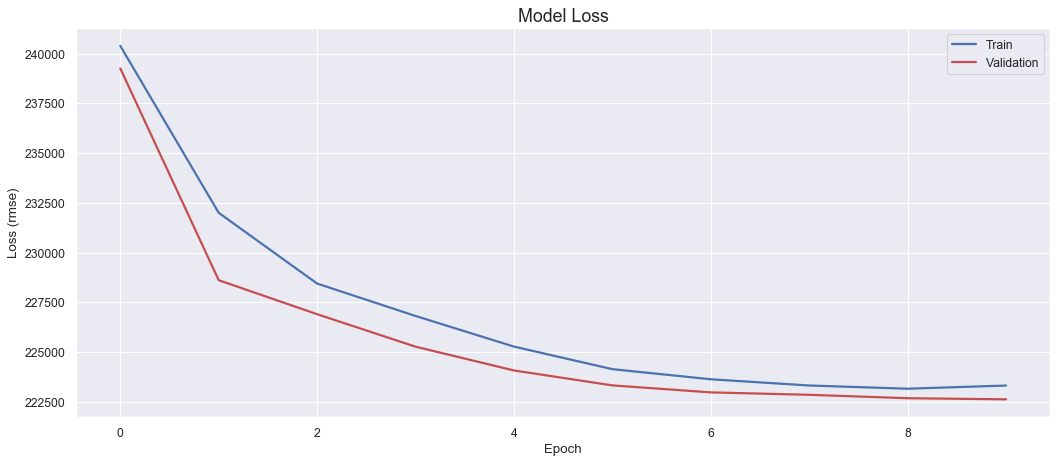

In [541]:
#plot training losses RMSE

fig,ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'],'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label ='Validation', linewidth = 2)
ax.set_title('Model Loss', fontsize=16)
ax.set_ylabel('Loss (rmse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

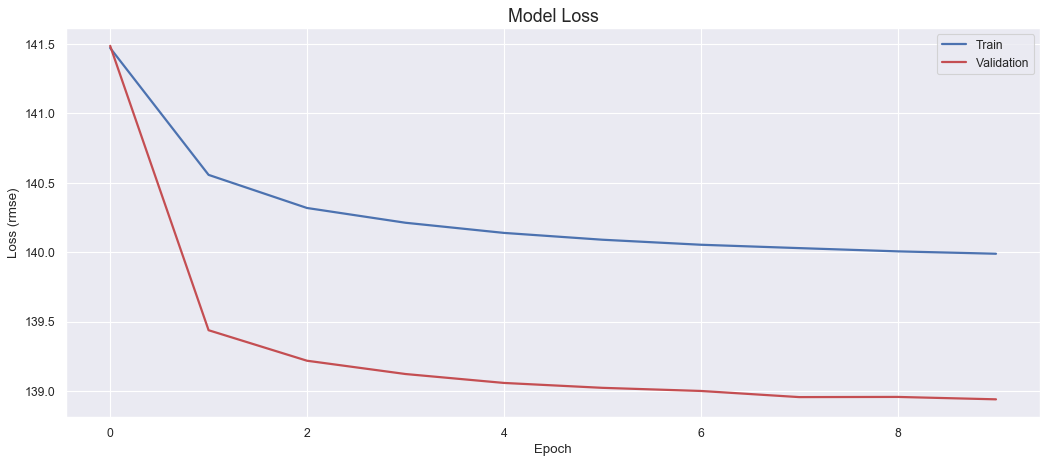

In [502]:
#plot training losses #MAE

fig,ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'],'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label ='Validation', linewidth = 2)
ax.set_title('Model Loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

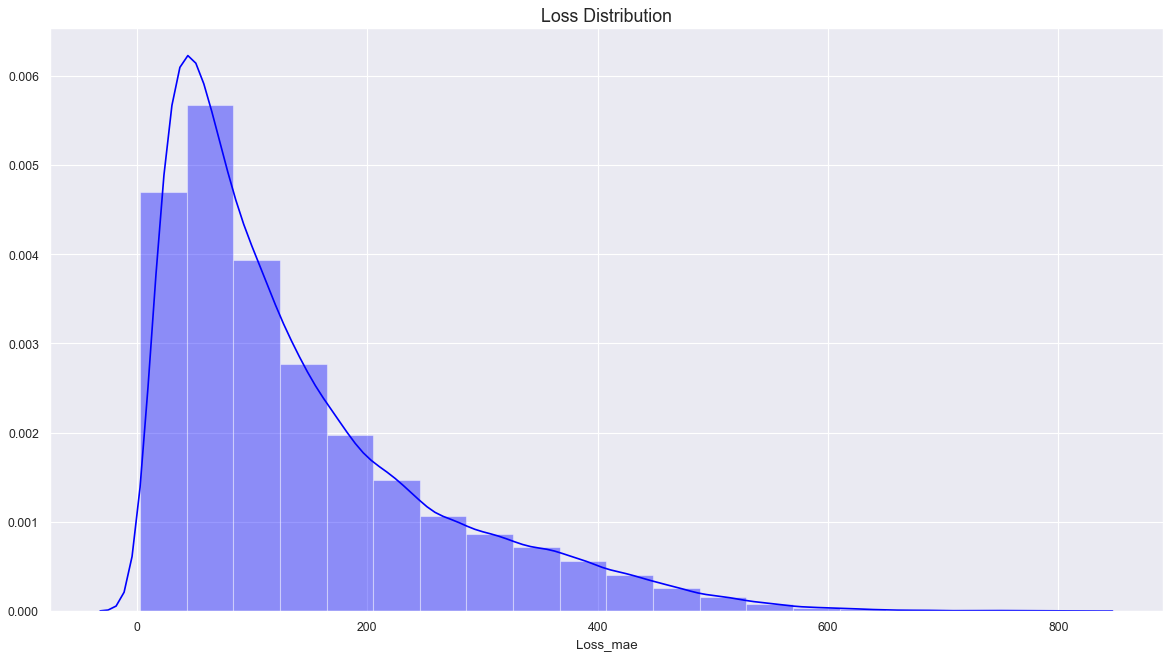

In [503]:
#plot loss distribution of the training set to determine suitable threshold value for identifying anomaly. 
#we can make sure that the threshold is set above the noise level so that false positives are not triggered(predict authentic but not)
X_pred = model.predict(X_train2)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns = np.arange(X_train2.shape[2]))
X_pred.index = np.arange(X_train2.shape[0])

scored = pd.DataFrame(index = np.arange(X_train2.shape[0]))
Xtrain = X_train2.reshape(X_train2.shape[0], X_train2.shape[2])
#scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
scored['Loss_rmse'] = np.sqrt(np.mean(X_pred-Xtrain)**2, axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize= 16)
sns.distplot(scored['Loss_mae'], bins =20, kde= True, color= 'blue')

In [504]:
nb_epochs = 50
batch_size = 10
history = model.fit(X_train2, X_train2, epochs=nb_epochs, batch_size = batch_size, validation_split = 0.05).history

Train on 76000 samples, validate on 4000 samples
Epoch 1/50
76000/76000 [==============================] - 29s 380us/sample - loss: 139.9810 - val_loss: 138.9221
Epoch 2/50
76000/76000 [==============================] - 29s 379us/sample - loss: 139.9655 - val_loss: 138.9333
Epoch 3/50
76000/76000 [==============================] - 29s 378us/sample - loss: 139.9643 - val_loss: 138.9406
Epoch 4/50
76000/76000 [==============================] - 29s 377us/sample - loss: 139.9521 - val_loss: 138.9261
Epoch 5/50
76000/76000 [==============================] - 29s 382us/sample - loss: 139.9547 - val_loss: 138.9030
Epoch 6/50
76000/76000 [==============================] - 31s 409us/sample - loss: 139.9458 - val_loss: 138.9190
Epoch 7/50
76000/76000 [==============================] - 29s 385us/sample - loss: 139.9433 - val_loss: 138.9264
Epoch 8/50
76000/76000 [==============================] - 29s 377us/sample - loss: 139.9413 - val_loss: 138.8904
Epoch 9/50
76000/76000 [=======================

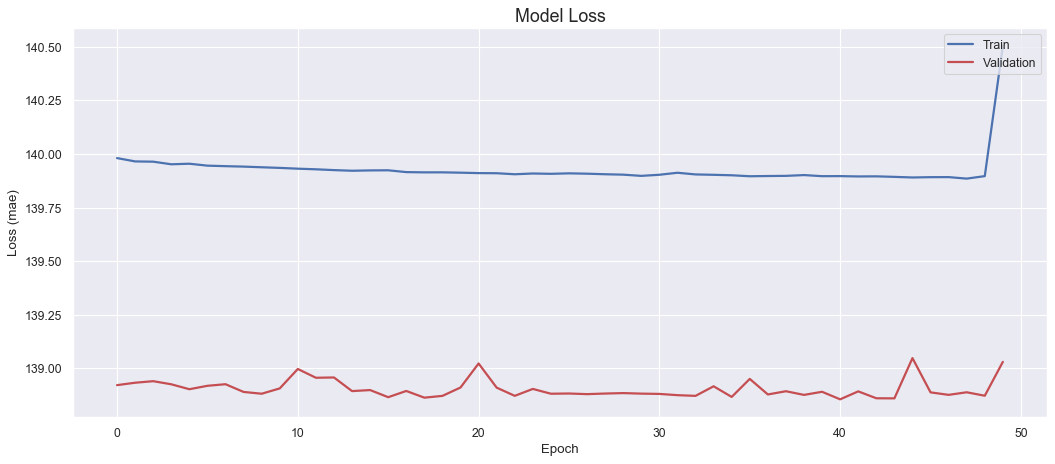

In [505]:
#plot training losses #MAE

fig,ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'],'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label ='Validation', linewidth = 2)
ax.set_title('Model Loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

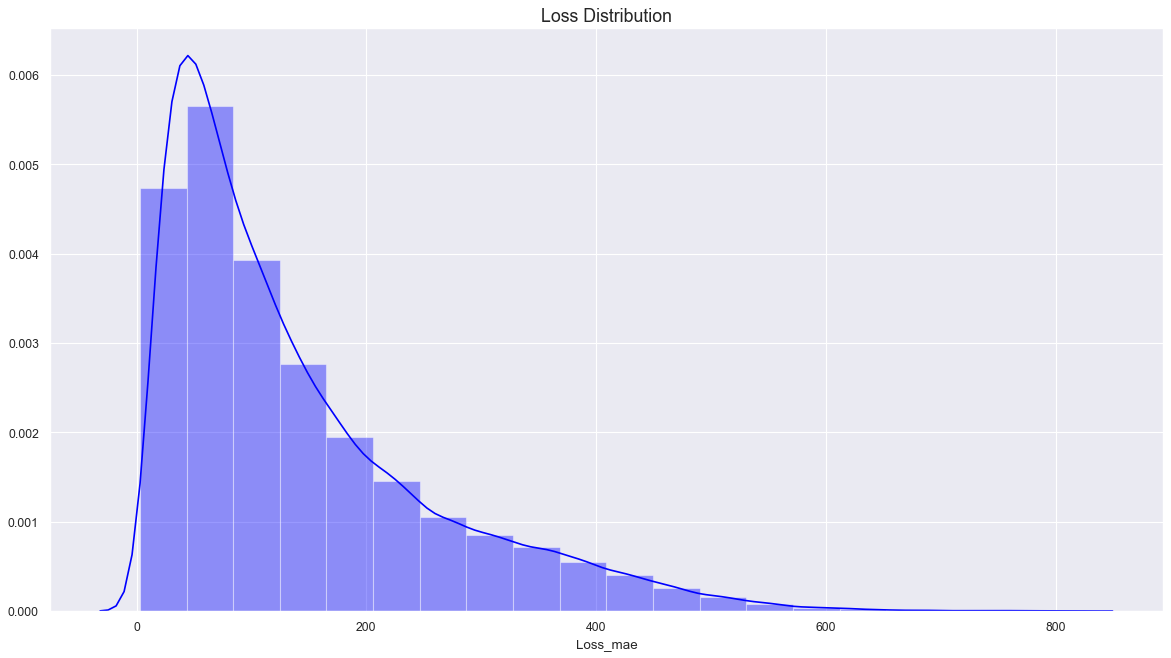

In [506]:
#plot loss distribution of the training set to determine suitable threshold value for identifying anomaly. 
#we can make sure that the threshold is set above the noise level so that false positives are not triggered(predict authentic but not)
X_pred = model.predict(X_train2)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns = np.arange(X_train2.shape[2]))
X_pred.index = np.arange(X_train2.shape[0])

scored = pd.DataFrame(index = np.arange(X_train2.shape[0]))
Xtrain = X_train2.reshape(X_train2.shape[0], X_train2.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xtrain), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize= 16)
sns.distplot(scored['Loss_mae'], bins =20, kde= True, color= 'blue')

In [523]:
decep_star = decep_samp.Stars[:80000].values

In [524]:
X_decep = np.hstack((X_decep, decep_star.reshape(80000,1)))

In [525]:
X_decep2 = X_decep.reshape(X_decep.shape[0], 1, X_decep.shape[1])

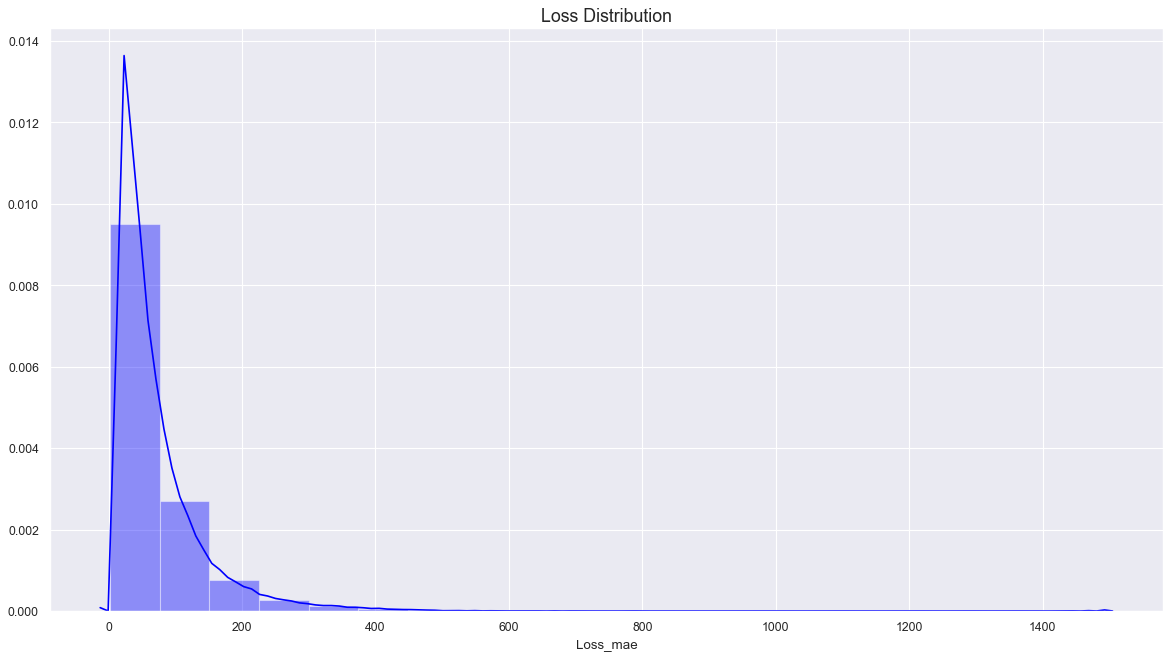

In [527]:
#X-decep loss distribution
X_pred = model.predict(X_decep2)
X_pred = X_pred.reshape(X_pred.shape[0], X_pred.shape[2])
X_pred = pd.DataFrame(X_pred, columns = np.arange(X_decep2.shape[2]))
X_pred.index = np.arange(X_decep2.shape[0])

scored = pd.DataFrame(index = np.arange(X_decep2.shape[0]))
Xdecep = X_decep2.reshape(X_decep2.shape[0], X_decep2.shape[2])
scored['Loss_mae'] = np.mean(np.abs(X_pred-Xdecep), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize= 16)
sns.distplot(scored['Loss_mae'], bins =20, kde= True, color= 'blue')

In [566]:
def autoencoder_model_new_2(X):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    L1 = LSTM(50, activation = 'relu', return_sequences = True)(inputs)
    L2 = LSTM(5, activation = 'relu', return_sequences = False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(5, activation = 'relu', return_sequences = True)(L3)
    L5 = LSTM(50, activation= 'relu', return_sequences = True)(L4)
    output = Dense(X.shape[2])(L5)
    model = Model(inputs=inputs, outputs=output)
    return model

In [576]:
model = autoencoder_model_new_2(X_train2)
model.compile(optimizer='rmsprop', loss = 'categorical_crossentropy')
model.summary()

Model: "model_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_32 (InputLayer)        [(None, 1, 301)]          0         
_________________________________________________________________
lstm_98 (LSTM)               (None, 1, 50)             70400     
_________________________________________________________________
lstm_99 (LSTM)               (None, 5)                 1120      
_________________________________________________________________
repeat_vector_23 (RepeatVect (None, 1, 5)              0         
_________________________________________________________________
lstm_100 (LSTM)              (None, 1, 5)              220       
_________________________________________________________________
lstm_101 (LSTM)              (None, 1, 50)             11200     
_________________________________________________________________
dense_79 (Dense)             (None, 1, 301)            153

In [577]:
#fit model to the data
nb_epochs = 10
batch_size = 10
history = model.fit(X_train2, X_train2, epochs=nb_epochs, batch_size = batch_size, validation_split = 0.1).history

Train on 72000 samples, validate on 8000 samples
Epoch 1/10
72000/72000 [==============================] - 37s 507us/sample - loss: nan - val_loss: nan
Epoch 2/10
72000/72000 [==============================] - 31s 433us/sample - loss: nan - val_loss: nan
Epoch 3/10
36610/72000 [==============>...............] - ETA: 14s - loss: nan

KeyboardInterrupt: 

In [570]:
history

{'loss': [141.11484896183015,
  140.465702846845,
  140.33106770303513,
  140.27454822646246,
  140.18841939926148,
  140.14659285439384,
  140.10406459437476,
  140.06715263207752,
  140.05117030567592,
  140.0247195423974],
 'val_loss': [139.8570952796936,
  139.6527874279022,
  139.55163355350496,
  139.5117875957489,
  139.4469515132904,
  139.4105244255066,
  139.38187000751495,
  139.3538026857376,
  139.3316310739517,
  139.34638153076173]}

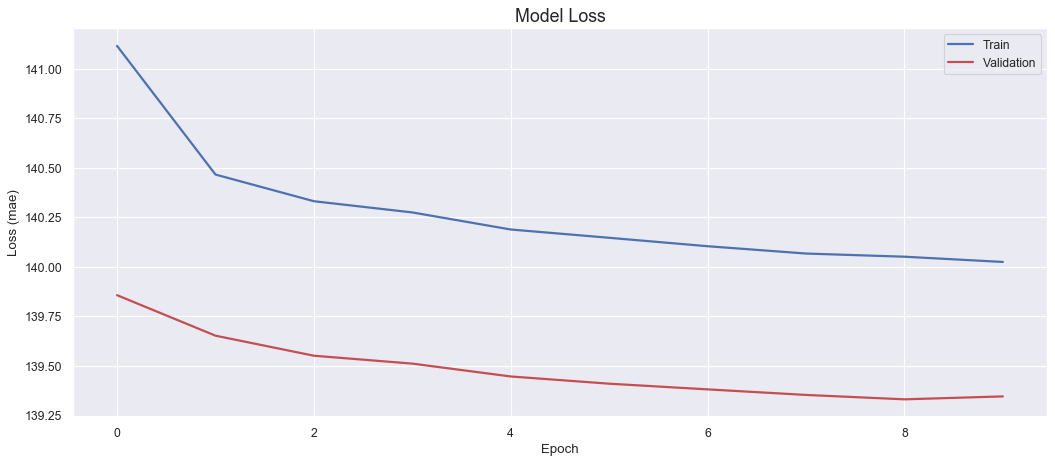

In [571]:
#plot training losses #MAE

fig,ax = plt.subplots(figsize=(14,6), dpi=80)
ax.plot(history['loss'],'b', label='Train', linewidth=2)
ax.plot(history['val_loss'], 'r', label ='Validation', linewidth = 2)
ax.set_title('Model Loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# REDO#2 since validation set is doing better than the training set which is odd.

In [578]:
def autoencoder_model_new_3(X,max_nb_words, embedding_dim):
    inputs = Input(shape=(X.shape[1], X.shape[2]))
    inputs_emb = Embedding(input_dim= max_nb_words, output_dim=embedding_dim )
    L1 = LSTM(40, activation = 'relu', return_sequences = True)(inputs_emb)
    L2 = LSTM(5, activation = 'relu', return_sequences = False)(L1)
    L3 = RepeatVector(X.shape[1])(L2)
    L4 = LSTM(5, activation = 'relu', return_sequences = True)(L3)
    L5 = LSTM(40, activation= 'relu', return_sequences = True)(L4)
    output = Dense(X.shape[2])(L5)
    model = Model(inputs=inputs_emb, outputs=output)
    return model

In [579]:
model = autoencoder_model_new_3(X_train2,max_nb_words = 300,embedding_dim=100)
model.compile(optimizer='adam', loss = 'mae')
model.summary()

AttributeError: 'Embedding' object has no attribute 'shape'

# Trying new model ENCODER-DECODER

In [596]:
X_train2.shape, X_train.shape

((80000, 1, 301), (80000, 301))

In [591]:
#Encoder Model
encoder_input = Input(shape=(None, len(X_train)))
encoder_lstm = LSTM(300, return_state= True, return_sequences = False)
encoder_outputs, encoder_h, encoder_c = encoder_lstm(encoder_input)
encoder_states = [encoder_h, encoder_c]

In [593]:
#Decoder Model
decoder_input = Input(shape=(None, len(X_train)))
decoder_lstm = LSTM(300, return_state= True, return_sequences = True)
decoder_out,_,_ = decoder_lstm(decoder_input, initial_state=encoder_states)
decoder_dense = Dense(len(X_train), activation = 'softmax')
decoder_out = decoder_dense(decoder_out)

In [585]:
model = Model(inputs=[encoder_input, decoder_input], outputs= [decoder_out])

In [595]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
history = model.fit([X_train], X_train, batch_size = 10, epochs= 10, validation_split=0.1)

ValueError: Error when checking model input: the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 2 array(s), for inputs ['input_34', 'input_36'] but instead got the following list of 1 arrays: [array([[0.000e+00, 0.000e+00, 0.000e+00, ..., 3.745e+03, 1.001e+03,
        5.000e+00],
       [0.000e+00, 0.000e+00, 0.000e+00, ..., 5.000e+00, 2.480e+02,
        5.000e+00],
       [0.000e+00, 0.00...